In [1]:
%load_ext watermark
import numpy as np
import pandas as pd

## Load the JupyterHub logs

In [2]:
columns = ['user', 'machine', 'session_start', 'session_end', 'session_length', 'log_file']

In [3]:
df_all = pd.read_csv("../data/jhub_logs.csv.gz", parse_dates=["session_start", "session_end"])
df_all["session_length"] = (df_all.session_end - df_all.session_start).dt.total_seconds().div(60)
df_all = df_all[columns]
df_all.head()

,user,machine,session_start,session_end,session_length,log_file
0,20d8049712498ad1e232,cheyenne,2019-10-17 09:04:13,2019-10-17 11:04:20,120.116667,3aebf8397c312169a649
1,20d8049712498ad1e232,cheyenne,2019-10-18 16:40:04,2019-10-18 16:42:08,2.066667,0af27edd1d54f8f64735
2,20d8049712498ad1e232,cheyenne,2019-10-18 11:44:28,2019-10-18 12:18:35,34.116667,044c2c11e5ebf6972a1d
3,20d8049712498ad1e232,cheyenne,2019-10-17 15:42:48,2019-10-17 15:46:53,4.083333,2055777649346c360841
4,20d8049712498ad1e232,cheyenne,2019-10-17 15:48:52,2019-10-17 15:57:59,9.116667,84be1d0c9fab13fcd4c1


In [5]:
df_all["machine"].unique()

array(['cheyenne', 'casper', nan], dtype=object)

In [8]:
dfs = {'all': df_all,
       'Cheyenne': df_all[df_all["machine"] == 'cheyenne'],
       'Casper': df_all[df_all["machine"] == 'casper']}

## Basic Statistics

Some basic statistics from the logs.

In [13]:
print(f'Total number of sessions:')
for name in dfs:
    print(f'{name.rjust(10)}:   {len(dfs[name])}')

Total number of sessions:
       all:   6477
  Cheyenne:   4021
    Casper:   2455


In [10]:
def print_span(name):
    print(f'Total span of {name} logs:  {dfs[name].session_end.max() - dfs[name].session_start.min()}')
    print(f'   From: {dfs[name].session_start.min()}')
    print(f'   To:   {dfs[name].session_end.max()}')

for name in dfs:
    print_span(name)
    print()

Total span of all logs:  255 days 23:00:58
   From: 2019-05-21 16:49:20
   To:   2020-02-01 15:50:18

Total span of Cheyenne logs:  243 days 17:19:44
   From: 2019-06-02 22:09:49
   To:   2020-02-01 15:29:33

Total span of Casper logs:  255 days 23:00:58
   From: 2019-05-21 16:49:20
   To:   2020-02-01 15:50:18



In [12]:
def print_lengths(name):
    print(f'Session Lengths on {name} [minutes]:')
    print(f'   Minimum:  {dfs[name].session_length.min()}')
    print(f'   Maximum:  {dfs[name].session_length.max()}')
    print(f'   Mean:     {dfs[name].session_length.mean()}')
    print(f'   Median:   {dfs[name].session_length.median()}')

for name in dfs:
    print_lengths(name)
    print()

Session Lengths on all [minutes]:
   Minimum:  0.0
   Maximum:  2494.6
   Mean:     113.3139051883879
   Median:   118.5

Session Lengths on Cheyenne [minutes]:
   Minimum:  0.0
   Maximum:  2494.6
   Mean:     118.66441183785128
   Median:   120.16666666666667

Session Lengths on Casper [minutes]:
   Minimum:  0.0
   Maximum:  1430.8166666666666
   Mean:     104.55040733197556
   Median:   79.28333333333333



In [14]:
print(f'Total Number of Unique Users:')
for name in dfs:
    print(f'{name.rjust(10)}:   {dfs[name].user.nunique()}')

Total Number of Unique Users:
       all:   180
  Cheyenne:   170
    Casper:   101


## Tutorials

Three tutorials have been given during the duration of the logs.  We note the dates for these tutorials so that we can reference their times in the plots below.

In [15]:
tutorials = {'jun': ["2019-06-03", "2019-06-05"],
             'sep': ["2019-09-18", "2019-09-20"],
             'oct': ["2019-10-16", "2019-10-18"]}

## Sessions by Day & Month

First, we take a look at the number of sessions per day over the span of the logs.

In [17]:
days = pd.date_range(dfs['all'].session_start.min(),
                     dfs['all'].session_end.max() + pd.DateOffset(days=1),
                     freq='D').normalize()
mons = pd.date_range(dfs['all'].session_start.min() - pd.DateOffset(months=1),
                     dfs['all'].session_end.max() + pd.DateOffset(months=1),
                     freq='MS').normalize()

In [25]:
sess_per_day = pd.DataFrame()
sess_per_mon = pd.DataFrame()
for name in dfs:
    sess_per_day[name] = 0.5 * (dfs[name].groupby(pd.cut(dfs[name].session_start, days)).size() +
                                dfs[name].groupby(pd.cut(dfs[name].session_end, days)).size()).rename(f'Sessions per Day ({name})')
    sess_per_mon[name] = 0.5 * (dfs[name].groupby(pd.cut(dfs[name].session_start, mons)).size() +
                                dfs[name].groupby(pd.cut(dfs[name].session_end, mons)).size()).rename(f'Sessions per Month ({name})')

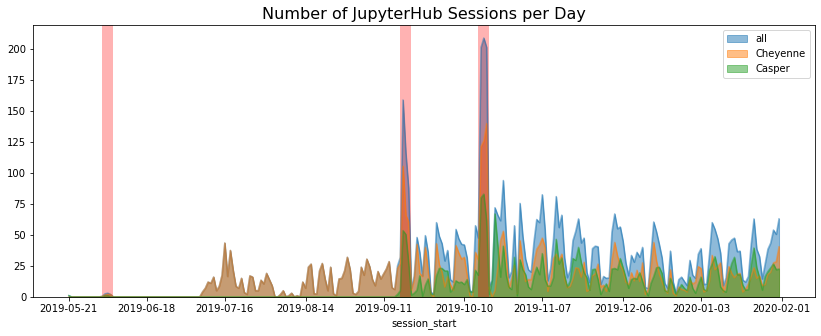

In [34]:
ax = sess_per_day.plot.area(figsize=(14,5), stacked=False)
xticks = np.linspace(0, len(days)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in xticks])
ax.set_title('Number of JupyterHub Sessions per Day', fontsize=16)
for tutorial in tutorials:
    t1, t2 = tutorials[tutorial]
    ax.axvspan(days.get_loc(t1)-1, days.get_loc(t2)+1, facecolor='r', alpha=.3, edgecolor='none')

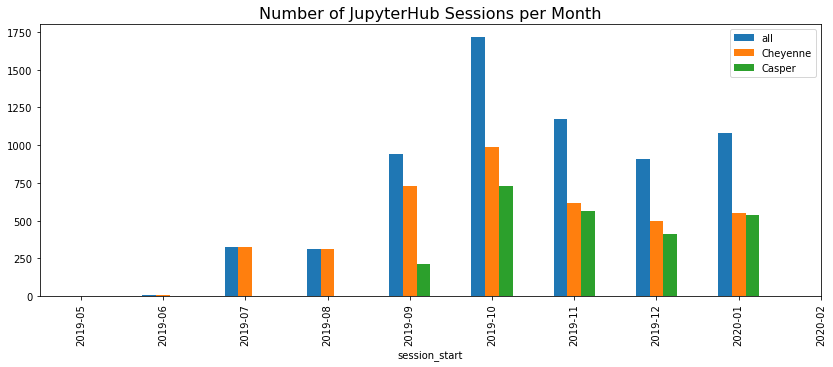

In [35]:
ax = sess_per_mon.plot.bar(figsize=(14,5))
xticks = np.linspace(0, len(mons)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([mons[i].strftime('%Y-%m') for i in xticks])
ax.set_title('Number of JupyterHub Sessions per Month', fontsize=16);

**NOTE:** You can see a definite up-tick in the number of sessions following the September and October tutorials.  During this period of time, from August through October, the average number of sessions per day and month more than doubles.

## Unique Users by Day & Month

Next, we look at the number of unique users per day and per month.

In [36]:
users_per_day = pd.DataFrame()
users_per_mon = pd.DataFrame()
for name in dfs:
    users_per_day[name] = 0.5 * (dfs[name].user.groupby(pd.cut(dfs[name].session_start, days)).nunique() +
                                 dfs[name].user.groupby(pd.cut(dfs[name].session_end, days)).nunique()).rename(f'Unique Users per Day ({name})')
    users_per_mon[name] = 0.5 * (dfs[name].user.groupby(pd.cut(dfs[name].session_start, mons)).nunique() +
                                 dfs[name].user.groupby(pd.cut(dfs[name].session_end, mons)).nunique()).rename(f'Unique Users per Month ({name})')

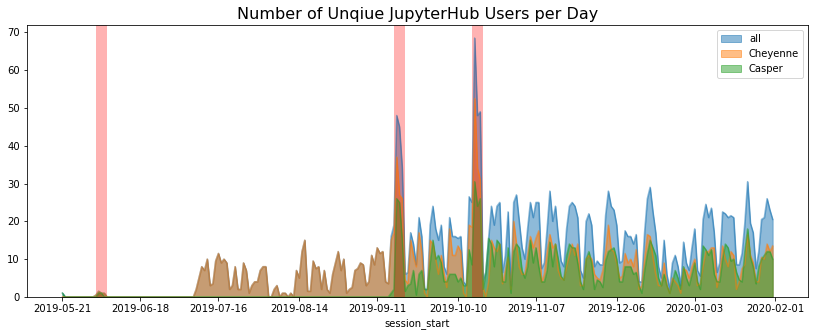

In [37]:
ax = users_per_day.plot.area(figsize=(14,5), stacked=False)
xticks = np.linspace(0, len(days)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([days[i].strftime('%Y-%m-%d') for i in xticks])
ax.set_title('Number of Unqiue JupyterHub Users per Day', fontsize=16)
for tutorial in tutorials:
    t1, t2 = tutorials[tutorial]
    ax.axvspan(days.get_loc(t1)-1, days.get_loc(t2)+1, facecolor='r', alpha=.3, edgecolor='none')

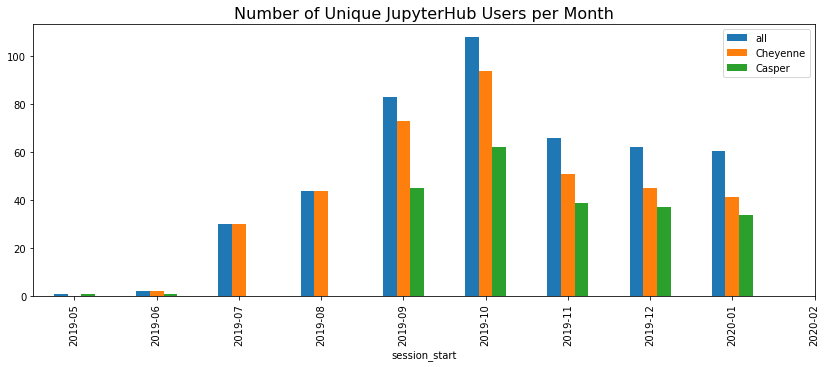

In [38]:
ax = users_per_mon.plot.bar(figsize=(14,5))
xticks = np.linspace(0, len(mons)-1, 10, dtype=int)
ax.set_xticks(xticks)
ax.set_xticklabels([mons[i].strftime('%Y-%m') for i in xticks])
ax.set_title('Number of Unique JupyterHub Users per Month', fontsize=16);

**NOTE:** Again, you can note a growth in users following each tutorial/hackathon (September and October).  

In [39]:
%watermark -iv -d -u

numpy  1.18.1
pandas 1.0.1
last updated: 2020-02-14
